In [1]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt
import numpy as np
from mesa.space import MultiGrid
import networkx as nx
from mesa.space import NetworkGrid
import time, enum, math
from mesa.datacollection import DataCollector
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt
import numpy as np
from mesa.space import MultiGrid
import networkx as nx
from mesa.space import NetworkGrid
import time, enum, math
from mesa.datacollection import DataCollector
import pandas as pd
from mesa.time import BaseScheduler
from mpmath import polylog
import sys
from networkx.utils import powerlaw_sequence
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import panel as pn
import panel.widgets as pnw
pn.extension()
pd.options.display.max_rows = None

### Update from copy_3.py file:
+ Change parameter value
+ change graph
+ change status
+ change contact
+ Add social_distancing

<h1 style="color:red">Note: 15th March is the date that the Australian Government enforced the isolation on incoming travellers from the oversee, it means that phase 2 started on this date (in the term of the model, stage 2 - social distancing - starts at step 73)</h1

## Confirmed cases Starting from 25th January

In [2]:
df =pd.read_excel(r'D:/testdata.xlsx')

## Transmission Rate

In [3]:
def getbeta(alpha, kappa): 
    beta = polylog(alpha-1, math.exp(-1 / kappa))/(polylog(alpha-2, math.exp(-1 / kappa))-polylog(alpha-1, math.exp(-1 / kappa)))
    return beta

In [4]:
beta = getbeta(2,5)
beta2 = getbeta(2,10)
beta3 = getbeta(2,15)
print("parameter: {0} and duration: {1}".format(beta,1/beta))
print("parameter: {0} and duration: {1}".format(beta2,1/beta2))
print("parameter: {0} and duration: {1}".format(beta3,1/beta3))

parameter: 0.607989487551965 and duration: 1.64476528044332
parameter: 0.328691269615568 and duration: 3.04236860677676
parameter: 0.233008774343887 and duration: 4.2916838767803


## Importation Model Outputs Starting from 1st January

In [5]:
df_importation = pd.read_csv(r'D:/notebooks-baseline/datafile/COVID_importations_travelRestrictions.csv')
file=df_importation['Estimated COVID importations']
file=file.astype('int')
file = np.array(file)
file
len(file)
file.sum()

5916

#### Overide Activation Function to fit with my work

In [6]:
class RandomActivation(BaseScheduler):
    """ A scheduler which activates each agent once per step, in random order,
    with the order reshuffled every step.

    This is equivalent to the NetLogo 'ask agents...' and is generally the
    default behavior for an ABM.

    Assumes that all agents have a step(model) method.

    """

    def step(self, social = False) -> None:
        """ Executes the step of all agents, one at a time, in
        random order.

        """
        self.social = social 
        for agent in self.agent_buffer(shuffled=True):
            agent.step(social)
 
        self.steps += 1
        self.time += 1

In [7]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    INFECTED = 2
    RECOVERED = 3 
    QUARANTINED = 4 
    

class CovidAgent(Agent):
    """This is a class of agents living inside the territory of Australia, each of them have been affected by imported agents"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id,model)
        self.state = State.SUSCEPTIBLE 
        self.incubation_time = 2
        self.recovery_time = 20
        self.rate_infected = 0.52
        self.rate_second_attack = 0.054
        self.quarantine_days = 14 
        self.quarantine_sd = 2 
        self.day = 0 
        self.day2=0
        self.immune_time = 90
    def step(self,social=False):
        """Take a step forwards in time in 2 condition""" 
        self.contact()
        self.status(social)
        
        

    def move(self):


        possible_steps = [node for node in self.model.grid.get_neighbors(self.pos, include_center=False) if self.model.grid.is_cell_empty(node)]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)

    def get_val(self):
        return 0 
    
    def status(self, social = False):
        """Check infection status 1 if loop for exposed condition and 1 for infected condition"""
        #social distancing policy


        """
        EXPOSED
        """
        if self.state == State.EXPOSED: 
            incubation_period = self.model.get_incubation_time() #4-8 days
            if self.day > incubation_period: 
                if social ==False:
                    if self.random.random()<0.54:
                        self.state = State.INFECTED
                        self.day = self.get_val()
                    else:
                        self.state = State.RECOVERED
                        self.day=self.get_val()
                        
                if social ==True:
                    successrate = 0.2 #chua biet 
                    if self.random.random()>successrate: 
                        self.state = State.RECOVERED
                        self.day = self.get_val()
                else:
                    self.state = State.INFECTED
                    self.day =self.get_val()
            else:
                self.day+=1

        elif self.state == State.INFECTED:   #INFECTED
            
            if self.day >= self.recovery_time:     
                if social ==False:
                    if self.random.random()<0.8: 
                        self.state = State.RECOVERED
                        self.day = self.get_val()
                    else: 
                        self.state = State.QUARANTINED
                        self.day = self.get_val()
                if social ==True:
                    if self.random.random()<0.9: 
                        self.state = State.QUARANTINED
                        self.day =self.get_val()
                    else: 
                        self.state = State.INFECTED
                        self.day=self.get_val()
            else:
                self.day+=1
        elif self.state == State.RECOVERED:
            if self.day>self.immune_time:
                if social == False:

                        if self.random.random()<self.model.rate_second_attack: 
                            self.state = State.SUSCEPTIBLE
                elif social ==True:
                    if self.random.random()<0.02: 
                        self.state = State.SUSCEPTIBLE
            else:
                self.day+=1

        elif self.state == State.QUARANTINED: #I am assuming that people confined themselves ulti they feel better

            if self.day> self.model.get_quarantine_time(): #people quarantined either become recovered after 14 days or still be confined at their space 
                if social ==False:
                    if self.random.random()<0.8: 
                        self.state = State.RECOVERED
                        self.day = self.get_val()
                    else:
                        self.state = State.INFECTED
                        self.day = self.get_val()
                if social ==True:
                    if self.random.random()<0.999: #82% of people are recovered after private confinement  
                        self.state = State.RECOVERED
                        self.day =self.get_val()
                    else: 
                        self.state = State.INFECTED
                        self.day =self.get_val() 
            else:
                self.day+=1


        elif self.state == State.SUSCEPTIBLE:
            self.day = 0



   
    def contact(self):
        """Find close contacts and infect"""
        """
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.EXPOSED
                    
                    other.incubation_time = self.model.get_incubation_time()
        """
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptile_neighbors = self.model.grid.get_cell_list_contents(neighbors_nodes)
        for other in susceptile_neighbors: 
            if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:  
                #if self.random.random() <model.ptrans:
                other.state = State.EXPOSED
                other.day = 0
                
    def isolated(self): 

        if self.state == State.INFECTED:
            self.state = State.QUARANTINED 
            self.quarantine_days = self.model.get_quarantine_time()

                    
            



In [8]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""

    def __init__(self, N=10, num_agents=7,num_infected=1,pcontact=0.4, ptrans=0.54, avg_node_degree=3, alpha=2,xmin=1,xmax=2,
                  recovery_rate=0.05, recovery_days=20, period_known_isolation=2.7, period_known_isolation_sd=0.9,
                 recovery_sd=2, incubation_time = 6 , incubation_time_sd = 2, rate_infected = 0.5, rate_second_attack=0.534,quarantine_days=14,quarantine_sd=2):
        #My shit here:
        self.num_nodes = N  
        self.pcontact=pcontact
        self.num_agents= num_agents
        self.alpha = alpha

        """All parameters"""
        prob = avg_node_degree / self.num_nodes
        self.rate_second_attack = rate_second_attack
        self.initial_outbreak_size = 1
        self.incubation_time = incubation_time
        self.incubation_time_sd = incubation_time_sd
        self.rate_infected = rate_infected
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.recovery_rate = recovery_rate
        self.recovery_days = recovery_days
        self.quarantine_days = quarantine_days
        self.quarantine_sd = quarantine_sd
        self.xmin = xmin
        self.xmax = xmax
        self.period_known_isolation=period_known_isolation
        self.period_known_isolation_sd=period_known_isolation_sd
        
        self.meta = self.create_net(self.alpha, self.xmin, self.xmax)
        #create network here: 
        self.G = nx.configuration_model(self.meta, create_using=nx.Graph())
        self.G.remove_edges_from(list(nx.selfloop_edges(self.G)))
        
        self.grid = NetworkGrid(self.G)

        self.schedule = RandomActivation(self) #activate the step of Agents in random orders
        self.running = True
        #self.dead_agents = []
        """2 types of agents: intra-agent and out-agent"""
        H=np.array(self.grid.G.nodes())
        self.list_of_random_nodes = self.random.sample(self.G.nodes(), self.num_agents)
        self.m=[element for element in H if element not in self.list_of_random_nodes]        
        for i, node in enumerate(self.G.nodes()):
            a = CovidAgent(i+1, self)
            a.state = State.SUSCEPTIBLE
            self.schedule.add(a)
            #add agent
            self.grid.place_agent(a, node)

            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.999,0.001])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()
            

        self.datacollector = DataCollector(            
            agent_reporters={"State": 'state'})
    def getbeta(self, alpha, kappa): 
        beta = polylog(alpha-1, math.exp(-1 / kappa))/(polylog(alpha-2, math.exp(-1 / kappa))-polylog(alpha-1, math.exp(-1 / kappa)))
        return beta
    def create_net(self, a,b,m): 
        def truncated_power_law(a, b,m):
            x = np.arange(b, m, dtype='float')
            pmf = 1/x**a
            pmf /= pmf.sum()
            return stats.rv_discrete(values=(range(b, m), pmf))

        a,b, m = self.alpha, self.xmin, self.xmax
        d = truncated_power_law(a=a,b=b, m=m)
        sample = d.rvs(size=self.num_nodes)
        return sample

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    def get_quarantine_time(self):
        return int(self.random.normalvariate(self.quarantine_days,self.quarantine_sd))
    def get_timefromsymptiononsettoisolation(self):
        return int(self.random.normalvariate(self.period_known_isolation,self.period_known_isolation_sd))
    def get_incubation_time(self):
        return int(self.random.normalvariate(self.incubation_time, self.incubation_time_sd))
    def step(self, second_phase=False, social = False):
        #Câu chuyện ở đây là ông cần phải có grid thì mới có agent để add vô, nếu chỉ có add_nodes thì nó quá đơn thuần và không có agent
                
        self.datacollector.collect(self)
        self.schedule.step(social)
        

        

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["blue", "orange", "red",])

def plot_grid(model,fig,layout='spring',title='Covid'):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)  
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    colors = [cmap(i) for i in states]

    nx.draw(graph, pos, node_size=100, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax,with_labels=True)
    ax.set_title(title)
    return
steps=10
fig,ax=plt.subplots(1,1,figsize=(16,10))

model = NetworkInfectionModel(100,num_agents=50, ptrans=0.1)

model.step()
f=plot_grid(model,fig,layout='spring',title="Covid Transmission")

In [9]:
import pandas as pd
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Exposed','Infected','Recovered','Quarantined']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return f
pop=10000
steps=50
st=time.time()
model = NetworkInfectionModel(pop,ptrans=0.54, xmin=2, xmax=60, rate_second_attack = 0.534, incubation_time=5, recovery_days=20)
for i in range(len(file)):
    model.step()
        
        
print("Running time:{}".format(time.time()-st))
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model))
print("___________________")
print(file)

NetworkXError: Invalid degree sequence: sum of degrees must be even, not odd

Text(170, 4000, '5th phase')

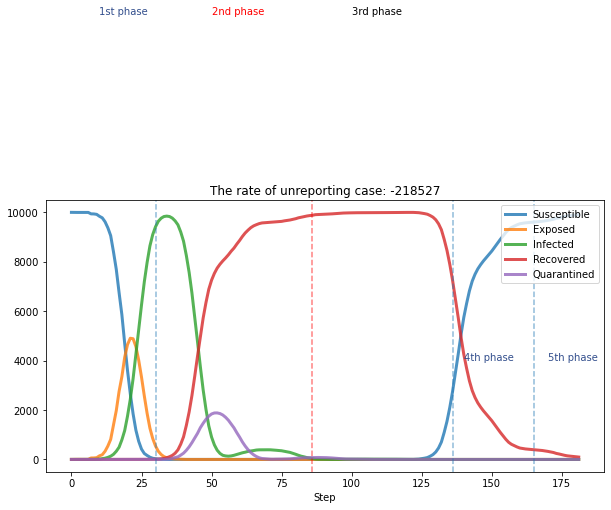

In [42]:
%matplotlib inline

f,ax=plt.subplots(1,1,figsize=(10,5))
plot_states(model,ax)
plt.title("The rate of unreporting case: {0}".format(100 -(get_column_data(model)['Infected'].sum())))
plt.legend(loc='upper right')

ax.axvline(x=30, linestyle='dashed', alpha=0.5)
ax.text(x=10, y=18000, s='1st phase', alpha=1, color='#334f8d')

ax.axvline(x=86, linestyle='dashed', alpha=0.5, color="red")
ax.text(x=50, y=18000, s='2nd phase', alpha=1, color='red')

ax.axvline(x=136, linestyle='dashed', alpha=0.5)
ax.text(x=100, y=18000, s='3rd phase', alpha=1, color='black')

ax.axvline(x=165, linestyle='dashed', alpha=0.5)
ax.text(x=140, y=4000, s='4th phase', alpha=1, color='#334f8d')

ax.text(x=170, y=4000, s='5th phase', alpha=1, color='#334f8d')


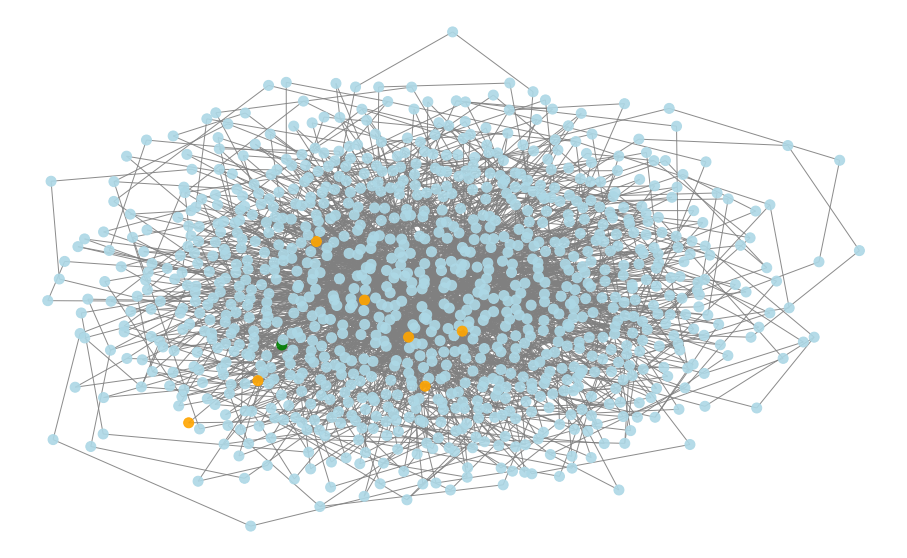

In [11]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["lightblue", "orange", "green",])

def plot_grid(model,fig,layout='spring',title=''):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)  
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    colors = [cmap(i) for i in states]

    nx.draw(graph, pos, node_size=100, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax)
    ax.set_title(title)
    return

#example usage
fig,ax=plt.subplots(1,1,figsize=(16,10))
model = NetworkInfectionModel(1000,ptrans=0.54, xmin=2, xmax=60, rate_second_attack = 0.534, incubation_time=5, recovery_days=20)
model.step()
f=plot_grid(model,fig,layout='kamada-kawai')

In [14]:
def run_model(pop, ptrans, degree, steps, delay, layout):

    model = NetworkInfectionModel(pop, ptrans=ptrans, xmin =2, xmax=20, avg_node_degree=degree)

    #fig,ax=plt.subplots(1,1,figsize=(10,8))
    fig1 = plt.Figure(figsize=(8,6))
    #ax1=fig1.add_subplot(1,1,1,label='a')
    grid_pane.object = fig1
    fig2 = plt.Figure(figsize=(8,6))
    ax2=fig2.add_subplot(1,1,1,label='b')
    states_pane.object = fig2 

    for i in range(steps):
        model.step()
        plot_grid(model,fig1,title='step=%s' %i, layout=layout)        
        grid_pane.param.trigger('object')
        ax2.clear()
        plot_states(model,ax2)
        ax2.set_xlim(0,steps)
        #states_pane.object = fig2
        states_pane.param.trigger('object')    
        time.sleep(delay)
    plt.clf()
    
#run_model(50, 20, 1, 20, 1)
grid_pane = pn.pane.Matplotlib()
states_pane = pn.pane.Matplotlib()
go_btn = pnw.Button(name='run',width=100,button_type='primary')
pop_input = pnw.IntSlider(name='population',value=1000,start=10,end=10000,step=10,width=100)
ptrans_input = pnw.FloatSlider(name='prob. trans',value=0.1,width=100)
degree_input = pnw.IntSlider(name='node degree',value=3,start=1,end=10,width=100)
steps_input = pnw.IntSlider(name='steps',value=20,start=5,end=100,width=100)
delay_input = pnw.FloatSlider(name='delay',value=.2,start=0,end=3,step=.2,width=100)
layout_input = pnw.Select(name='layout',options=['spring','circular','kamada-kawai'],width=100)
widgets = pn.WidgetBox(go_btn,pop_input,ptrans_input,steps_input,delay_input,layout_input)

def execute(event):
    run_model(pop_input.value, ptrans_input.value, degree_input.value, steps_input.value, delay_input.value, layout_input.value)
go_btn.param.watch(execute, 'clicks')
    
pn.Row(pn.Column(widgets),grid_pane,states_pane,sizing_mode='stretch_width')

Row(sizing_mode='stretch_width')
    [0] Column
        [0] WidgetBox
            [0] Button(button_type='primary', name='run', width=100)
            [1] IntSlider(end=10000, name='population', start=10, step=10, value=1000, value_throttled=1000, width=100)
            [2] FloatSlider(name='prob. trans', value=0.1, value_throttled=0.1, width=100)
            [3] IntSlider(end=100, name='steps', start=5, value=20, value_throttled=20, width=100)
            [4] FloatSlider(end=3, name='delay', step=0.2, value=0.2, value_throttled=0.2, width=100)
            [5] Select(name='layout', options=['spring', 'circular', ...], value='spring', width=100)
    [1] Matplotlib(None)
    [2] Matplotlib(None)

In [126]:
100-(801100/get_column_data(model)['Infected'][30:].sum())

79.55908244239748

In [127]:
a=df_confirmed['confirmed']

In [128]:
a=a[:182]
len(a)
a=a[:157]

NameError: name 'a' is not defined

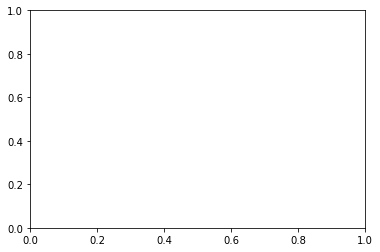

In [52]:
fig = plt.subplot()
x1 = np.linspace(0,181,182)
y1 = get_column_data(model)['Infected']
x2 = x1[25:]
y2 = a
x3= np.linspace(25,267,242)
y4=b
y5=file
fig.plot(x1,y1, label="model")
fig.plot(x2,y2, label="scale real")
fig.plot(x3,y4, label="full real")
fig.plot(x1,y5, label="imported")
fig.legend()

In [130]:
deg = sorted([d for i,d in model.G.degree])

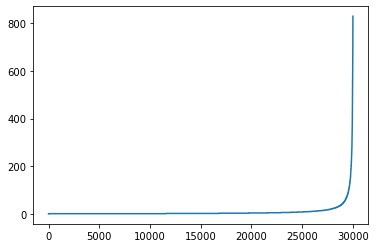

In [131]:
plt.plot(deg)

In [132]:
deg = np.array(deg)
deg

array([  1,   1,   1, ..., 784, 807, 828])

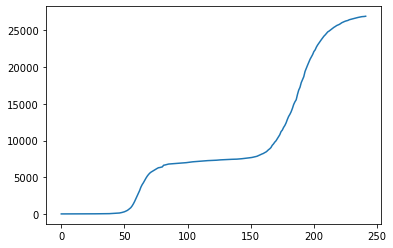

In [133]:
b=df_confirmed['confirmed']
plt.plot(b)

In [146]:
df_im = pd.DataFrame(file)

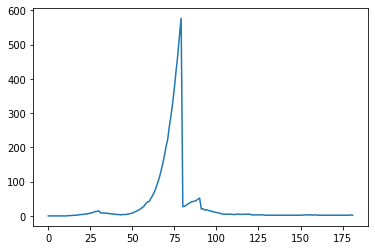

In [25]:
d=get_column_data(model)[11:]


In [27]:
d

,Susceptible,Exposed,Infected,Recovered,Quarantined
Step,,,,,
11,24000,0,0,0,0
12,23997,3,1,0,0
13,23986,14,2,0,0
14,23983,17,3,0,0
15,23933,66,6,0,0
16,23846,152,9,0,0
17,23664,330,12,3,0
18,23324,656,26,6,0
19,21791,2152,53,20,0


In [269]:
df_cul= pd.read_csv(r'C:/Users/n10648771/OneDrive - Queensland University of Technology/DataScienceCovid/COVID-19_Data-master/Data/COVID_AU_national_cumulative.csv')

In [22]:
random.normalvariate(6,2)

9.981492234887524